In [15]:
import pandas as pd
from math import *
import os
import re
import matplotlib.pyplot as plt
import numpy as np

In [16]:
parent_dir = 'SIMSbinary'
data_lst = []
for f in os.listdir(parent_dir):
    if "SIMS" in f:
        seed = f.split(".")[0].split('-')[-1]
        nsim = f.split(".")[0].split('-')[-2]
        if "c." in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            data['crossfit'] = True

            data['nsim'] = nsim
            data['seed'] = seed
            data_lst.append(data)
        else:
            data = pd.read_csv(os.path.join(parent_dir, f))
            data['crossfit'] = False
            data['nsim'] = nsim
            data['seed'] = seed
            data_lst.append(data)



SIMS = pd.concat(data_lst)
df = SIMS.copy()
df = df[df["seed"] == "1"]
df = df.loc[:, ~df.isna().all()]
df = df.dropna(axis = 0)

print(df.shape)
df.head()



(10000, 21)


,ATEBoot00,ATENaive,RegressionTrue,P2SLS,ATEBoot10,ATEBoot11,ATEBoot12,PartialCorrTYU,confounding,ATEBoot00pval,...,ATENaivepval,ATEBoot10pval,ATEBoot11pval,ATEBoot12pval,ATE2pval,ground_truthpval,bTY,crossfit,nsim,seed
0,1.431577,1.433053,0.585610,-6.810032,1.430903,2.232117,-17.982583,0.121913,0,0.000823,...,0.000817,0.000825,0.070397,0.555893,0.063238,0.290802,0.955956,False,100,1
1,0.642962,0.659931,0.506846,0.356286,0.626894,0.479924,0.480556,0.119004,0,0.137385,...,0.125292,0.148573,0.303750,0.303060,0.448139,0.257140,0.855856,False,100,1
2,0.304840,0.746133,-0.354541,2.098632,0.272171,0.784625,-0.393165,0.319510,1,0.750297,...,0.421568,0.776307,0.355631,0.722524,0.004541,0.720095,-0.943944,False,100,1
3,0.046449,0.274874,0.142760,0.491981,0.066505,-0.023944,-0.036258,-0.014220,1,0.940932,...,0.657332,0.915009,0.969644,0.954115,0.301536,0.830016,-0.441441,False,100,1
4,0.763878,0.763975,0.920654,0.952009,0.761813,0.915675,0.912106,0.192179,0,0.104669,...,0.104359,0.105043,0.054099,0.054744,0.036422,0.058452,0.881882,False,100,1


In [17]:
df = SIMS.copy()
df = df[df["seed"] == "1"]

df = df.loc[:, ~df.isna().all()]

df['nsim'].value_counts()

nsim
1000    10000
100     10000
Name: count, dtype: int64

In [18]:
def error(x, y, squared = True):
    if squared:
        return (x - y)**2
    else:
        return abs(x - y)

In [19]:
df['error00'] = error(df['ATEBoot00'], df['bTY'])
df['errorNaive'] = error(df['ATENaive'], df['bTY'])
df['error10'] = error(df['ATEBoot10'], df['bTY'])
df['error11'] = error(df['ATEBoot11'], df['bTY'])
df['error12'] = error(df['ATEBoot12'], df['bTY'])


df['error3'] = error(df['P2SLS'], df['bTY'])
df['oracle'] = error(df['RegressionTrue'], df['bTY'])



In [20]:
grouped_df = df.groupby(['nsim'])

In [21]:
grouped_df['error00'].mean(), grouped_df['errorNaive'].mean(), grouped_df['error00'].median(), grouped_df['errorNaive'].median()

(nsim
 100     19.705816
 1000     1.993157
 Name: error00, dtype: float64,
 nsim
 100     6.231244
 1000    2.233551
 Name: errorNaive, dtype: float64,
 nsim
 100     0.711556
 1000    0.348678
 Name: error00, dtype: float64,
 nsim
 100     0.829783
 1000    0.450576
 Name: errorNaive, dtype: float64)

In [22]:
grouped_df['error10'].mean(), grouped_df['error11'].mean(), grouped_df['error12'].mean(), grouped_df['error10'].median(), grouped_df['error11'].median(), grouped_df['error12'].median()

(nsim
 100     9.084031e+22
 1000    1.945499e+00
 Name: error10, dtype: float64,
 nsim
 100     12.182907
 1000     2.838874
 Name: error11, dtype: float64,
 nsim
 100       4879.475489
 1000    130710.567838
 Name: error12, dtype: float64,
 nsim
 100     0.697183
 1000    0.344869
 Name: error10, dtype: float64,
 nsim
 100     0.566254
 1000    0.074761
 Name: error11, dtype: float64,
 nsim
 100     0.686828
 1000    0.096262
 Name: error12, dtype: float64)

In [23]:
grouped_df['error3'].mean(), grouped_df['error3'].median()  

(nsim
 100     1.523364e+27
 1000    2.040225e+02
 Name: error3, dtype: float64,
 nsim
 100     0.598878
 1000    0.078515
 Name: error3, dtype: float64)

In [24]:
grouped_df['oracle'].mean(), grouped_df['oracle'].median()

(nsim
 100     1531.687577
 1000       0.066336
 Name: oracle, dtype: float64,
 nsim
 100     0.272830
 1000    0.024166
 Name: oracle, dtype: float64)

(-0.15, 0.15)

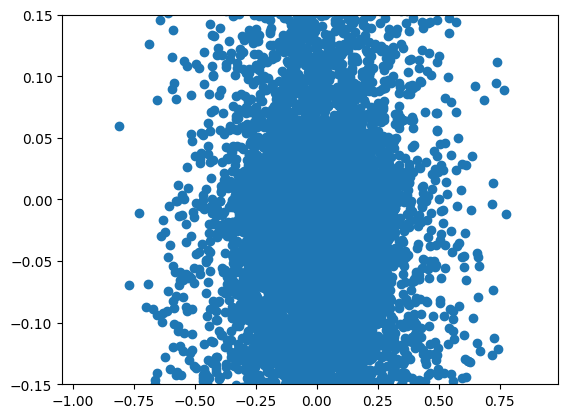

In [25]:
# plt.scatter(df['PartialCorrTYU'], df['error11'])
# plt.scatter(df['PartialCorrTYU'], df['error12'])
plt.scatter(df['PartialCorrTYU'], df['error00'] - df['errorNaive'])
plt.ylim(-0.15, 0.15)


In [26]:
from scipy.stats import bootstrap
df['corCategorries'] = pd.cut(df['PartialCorrTYU'].abs(), 
                             bins=[-float('inf'), 0.25, 0.75, float('inf')],
                             labels=['low', 'medium', 'high'])
df['diff_error'] = df['errorNaive'] - df['error00']

# Calculate medians and confidence intervals
medians = df.groupby(['nsim','corCategorries'])['diff_error'].median()
cis = df.groupby(['nsim','corCategorries']).apply(lambda x: bootstrap((x['diff_error'],), np.median, confidence_level=0.95))

# Create dataframe with median and CI bounds
results_df = pd.DataFrame({
    'median': medians,
    'ci_lower': [ci.confidence_interval[0] for ci in cis],
    'ci_upper': [ci.confidence_interval[1] for ci in cis]
})

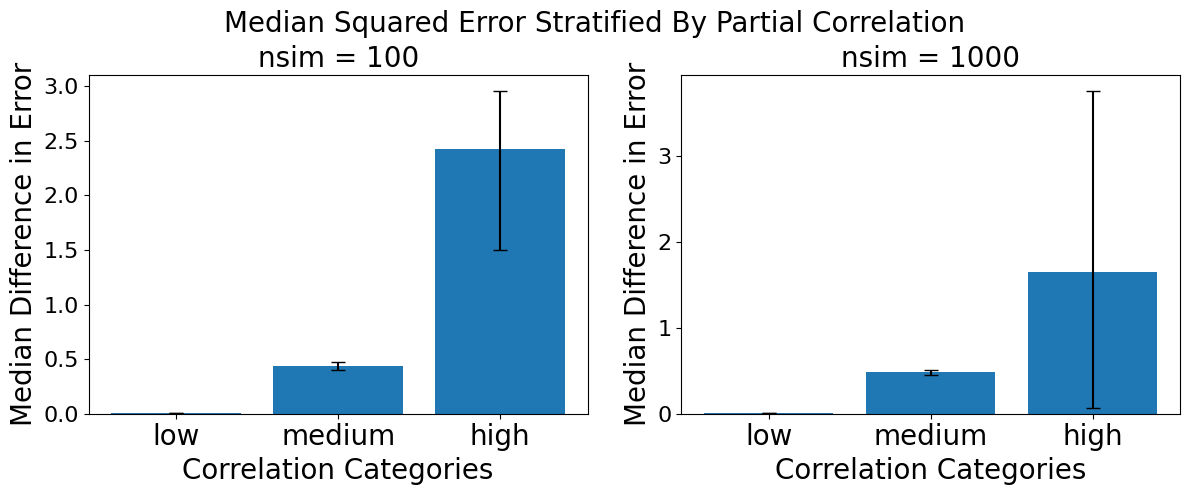

In [27]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for nsim = 100
results_100 = results_df.xs("100", level='nsim')
ax1.bar(range(len(results_100)), results_100['median'])
ax1.errorbar(range(len(results_100)), results_100['median'],
            yerr=[results_100['median'] - results_100['ci_lower'],
                  results_100['ci_upper'] - results_100['median']],
            fmt='none', capsize=5, color='black')
ax1.set_xticks(range(len(results_100)))
ax1.set_xticklabels(results_100.index, fontsize=20)
ax1.set_ylabel('Median Difference in Error', fontsize=20)
ax1.set_xlabel('Correlation Categories', fontsize=20)
ax1.set_title('nsim = 100', fontsize=20)
ax1.tick_params(axis='y', labelsize=16)

# Plot for nsim = 1000
results_1000 = results_df.xs("1000", level='nsim')
ax2.bar(range(len(results_1000)), results_1000['median'])
ax2.errorbar(range(len(results_1000)), results_1000['median'],
            yerr=[results_1000['median'] - results_1000['ci_lower'],
                  results_1000['ci_upper'] - results_1000['median']],
            fmt='none', capsize=5, color='black')
ax2.set_xticks(range(len(results_1000)))
ax2.set_xticklabels(results_1000.index, fontsize=20)
ax2.set_ylabel('Median Difference in Error', fontsize=20)
ax2.set_xlabel('Correlation Categories', fontsize=20)
ax2.set_title('nsim = 1000', fontsize=20)
ax2.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Make room for suptitle
plt.suptitle("Median Squared Error Stratified By Partial Correlation", fontsize=20)
plt.savefig('figs/median_error_by_correlation_binary.png')

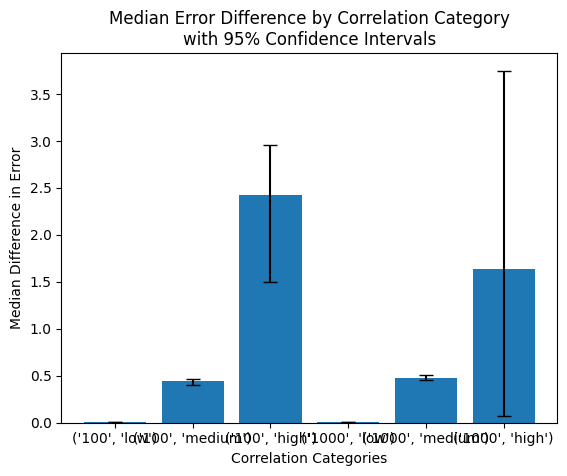

In [28]:
# Create bar plot with confidence intervals
ax = plt.bar(range(len(results_df)), results_df['median'])

# Add error bars using confidence intervals
plt.errorbar(range(len(results_df)), results_df['median'],
            yerr=[results_df['median'] - results_df['ci_lower'], 
                  results_df['ci_upper'] - results_df['median']],
            fmt='none', capsize=5, color='black')

# Customize plot
plt.xticks(range(len(results_df)), results_df.index)
plt.ylabel('Median Difference in Error')
plt.xlabel('Correlation Categories')
plt.title('Median Error Difference by Correlation Category\nwith 95% Confidence Intervals')

plt.savefig('figs/error_by_correlation.png')
